# Robot Vision Notebook (COMP34212)

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-14 21:01:41.510566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 21:01:41.725970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 21:01:41.726005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 21:01:41.760770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 21:01:41.834589: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.keras.backend.clear_session()

### Global Constants & Variables

In [3]:
# Image Constants
IMAGES_PATH = "icub"
IMG_CHANNELS = 3
IMG_DOWNSCALE_FACTOR = 4
IMG_ROWS = int(256/IMG_DOWNSCALE_FACTOR)
IMG_COLS = int(256/IMG_DOWNSCALE_FACTOR)
N_CLASSES = len(os.listdir(IMAGES_PATH))

# Training constants
BATCH_SIZE = 32 
N_EPOCH = 20 
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
OPTIM = Adam(LEARNING_RATE)

### Data Pre-Processing

In [4]:
objects = os.listdir(IMAGES_PATH)

mapping = {object_name: object_index for object_index, object_name in enumerate(objects)}

print(mapping)

{'ringbinder': 0, 'hairclip': 1, 'pencilcase': 2, 'wallet': 3, 'cellphone': 4, 'book': 5, 'hairbrush': 6, 'perfume': 7, 'sunglasses': 8, 'mouse': 9}


In [5]:
# https://www.askpython.com/python-modules/numpy/downsampling-arrays-image-processing
# For downsampling (can swap to opencv)

In [6]:
# Input images
image_dataset_x = []
image_dataset_y = []

def load_images(path, downscale_factor):
    """Cycles through folder structure inputting images and classifications to x and y lists and downsamples image by given factor"""
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            if item_path.split("/")[-1] not in ["ROT2D", "ROT3D", "SCALE", "TRANSL", "right"]: # folders to avoid
                load_images(item_path, downscale_factor)
        else:
            if item_path.endswith(".jpg"):
                image = cv2.imread(item_path)
                if image.shape == (256, 256, 3):
                    # downsampled_image = image[::downscale_factor, ::downscale_factor, :]
                    downsampled_image = cv2.resize(image, None, fx=1/downscale_factor, fy=1/downscale_factor)
                    image_dataset_x.append(downsampled_image)
                    category = item_path.split("/")[1] # swap to "\\" if using windows
                    image_dataset_y.append(mapping.get(category))
                    print(item_path)

load_images(IMAGES_PATH, IMG_DOWNSCALE_FACTOR)

icub/ringbinder/ringbinder7/MIX/day4/left/00001618.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001627.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001762.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001661.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001632.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001675.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001788.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001596.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001595.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001552.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001636.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001725.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001574.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001644.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001704.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001581.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001735.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001589.jpg
icub/ringb

In [7]:
# Convert lists into np.arrays
image_dataset_x = np.array(image_dataset_x)
image_dataset_y = np.array(image_dataset_y)

In [8]:
# Print shapes of both np arrays
print(image_dataset_x.shape)
print(image_dataset_y.shape)

(61045, 64, 64, 3)
(61045,)


In [9]:
# Print distribution of classes
counts = np.unique(image_dataset_y, return_counts=True)
for i in range(N_CLASSES):
    print(f"{list(mapping.keys())[i]}: {counts[1][i]}")

ringbinder: 5363
hairclip: 6736
pencilcase: 6734
wallet: 5410
cellphone: 5718
book: 6666
hairbrush: 6186
perfume: 6294
sunglasses: 5426
mouse: 6512


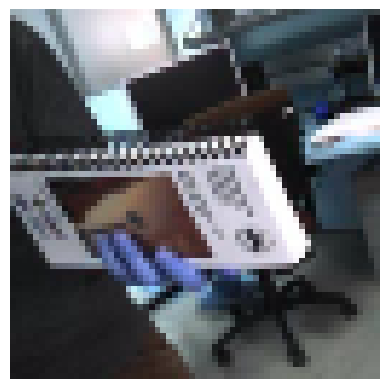

In [10]:
# Display sample image
plt.imshow(image_dataset_x[0])
plt.axis('off') 
plt.show()

In [11]:
# Split dataset into training and testing
input_X_train, input_X_test, output_y_train, output_y_test = train_test_split(image_dataset_x, image_dataset_y, test_size=0.2, random_state=42, stratify=image_dataset_y)

In [12]:
del image_dataset_x
del image_dataset_y

In [13]:
# One-hot encode
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES) 

In [14]:
del output_y_train
del output_y_test

In [15]:
# Normalise
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255

In [16]:
input_X_train.shape

(48836, 64, 64, 3)

### Model Construction, Training & Evaluation

In [17]:
# network definition

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

print('CNN network definition.')

CNN network definition.


2024-04-14 21:02:21.862891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 21:02:21.963705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 21:02:21.963813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                        

In [19]:
# Training/fitting of the DNN model
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Epoch 1/20


2024-04-14 21:02:23.574900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 21:02:23.646942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-14 21:02:23.773278: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 21:02:24.009794: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 8s 5ms/step - loss: 1.6246 - accuracy: 0.4285 - val_loss: 1.0921 - val_accuracy: 0.6128
Epoch 2/20
1221/1221 [==============================] - 6s 5ms/step - loss: 1.0042 - accuracy: 0.6440 - val_loss: 0.7845 - val_accuracy: 0.7304
Epoch 3/20
1221/1221 [==============================] - 6s 5ms/step - loss: 0.7487 - accuracy: 0.7324 - val_loss: 0.6983 - val_accuracy: 0.7605
Epoch 4/20
1221/1221 [==============================] - 6s 5ms/step - loss: 0.5880 - accuracy: 0.7896 - val_loss: 0.5942 - val_accuracy: 0.7949
Epoch 5/20
1221/1221 [==============================] - 6s 5ms/step - loss: 0.4850 - accuracy: 0.8298 - val_loss: 0.5814 - val_accuracy: 0.7988
Epoch 6/20
1221/1221 [==============================] - 5s 4ms/step - loss: 0.3991 - accuracy: 0.8602 - val_loss: 0.5731 - val_accuracy: 0.8098
Epoch 7/20
1221/1221 [==============================] - 5s 4ms/step - loss: 0.3420 - accuracy: 0.8794 - val_loss: 0.5270 - val_accuracy: 0.8308
Epo

382/382 [==============================] - 1s 2ms/step - loss: 0.5057 - accuracy: 0.8602

Test score/loss: 0.5056518912315369
Test accuracy: 0.8601850867271423
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


KeyError: 'val_accuracIMG_ROWSy'

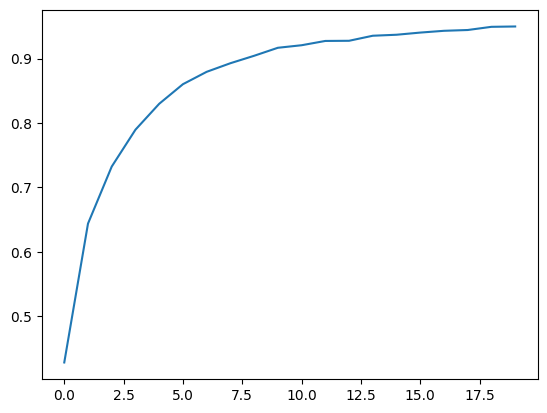

In [21]:
# Testing
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accurac'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
predictions = model.predict(input_X_test)

382/382 [==============================] - 0s 1ms/step


In [ ]:
cm = confusion_matrix(np.argmax(output_Y_test, axis=1), np.argmax(predictions, axis=1))

Text(0.5, 1.0, 'Correlation Matrix')

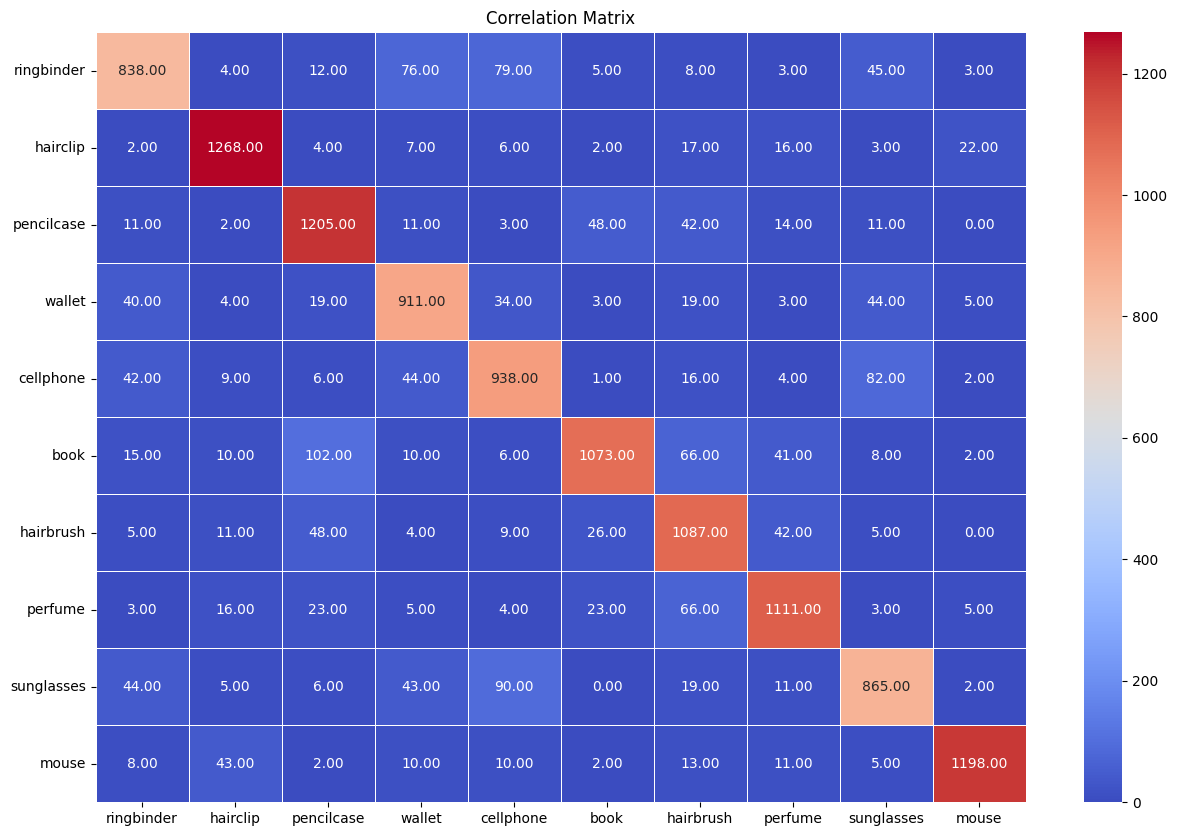

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, xticklabels=objects, yticklabels=objects) 
plt.yticks(rotation=0)
plt.title('Correlation Matrix')